### B반 최효진

OO공장의 고객사에서 최근 들어 "Scale 불량 발생 증가"라는 이슈가 발생했다. 그 원인을 분석해 본 결과 압연공정에서 Scale 불량이 급증한 것을 확인할 수 있었다. 그래서 데이터를 수집하여 다양한 분석을 통해 불량 발생의 근본 원인을 찾고 개선을 위한 최적의 조건을 도출하고자 한다.

In [1]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.tree import export_graphviz
from sklearn.linear_model import LogisticRegression

from sklearn.preprocessing import StandardScaler
from statsmodels.api import Logit
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

import seaborn as sns
from statsmodels.formula.api import ols
from statsmodels.api import qqplot, add_constant
import statsmodels.formula.api as smf

from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler

from statsmodels.api import Logit
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

import graphviz
import os

In [6]:
matplotlib.rc('font',family='Malgun Gothic')

os.environ['PATH'] += os.pathsep + 'C:/Users/Enok/Anaconda3/Library/bin/graphviz'

In [11]:
df_raw = pd.read_csv("C:\\Users\\pobby\\Downloads\\SCALE불량.csv",engine = 'python',encoding = "euc_kr")
df_raw.head()

PLATE_NO         ROLLING_DATE SCALE        SPEC STEEL_KIND  PT_THK  \
0  PB562774  2008-08-01:00:00:15    양품  AB/EH32-TM         T1   32.25   
1  PB562775  2008-08-01:00:00:16    양품  AB/EH32-TM         T1   32.25   
2  PB562776  2008-08-01:00:00:59    양품   NV-E36-TM         T8   33.27   
3  PB562777  2008-08-01:00:01:24    양품   NV-E36-TM         T8   33.27   
4  PB562778  2008-08-01:00:01:44    양품  BV-EH36-TM         T8   38.33   

   PT_WDTH  PT_LTH  PT_WGT FUR_NO  ...  FUR_HZ_TEMP  FUR_HZ_TIME  FUR_SZ_TEMP  \
0     3707   15109   14180    1호기  ...         1144          116         1133   
1     3707   15109   14180    1호기  ...         1144          122         1135   
2     3619   19181   18130    2호기  ...         1129          116         1121   
3     3619   19181   18130    2호기  ...         1152          125         1127   
4     3098   13334   12430    3호기  ...         1140          134         1128   

   FUR_SZ_TIME  FUR_TIME  FUR_EXTEMP  ROLLING_TEMP_T5  HSB ROLLING_DESCALING  \
0           59       282        1133              934   적용                 8   
1           53       283        1135              937   적용                 8   
2           55       282        1121              889   적용                 8   
3           68       316        1127              885   적용                 8   
4           48       314        1128              873   적용                 8   

   WORK_GR  
0       2조  
1       2조  
2       3조  
3       3조  
4       1조  

[5 rows x 21 columns]

In [12]:
#불량 발생에 영향을 주지 않은 변수 제거
df_raw.drop(["PLATE_NO","ROLLING_DATE","SPEC","STEEL_KIND","WORK_GR","FUR_NO"],axis=1,inplace=True)

In [13]:
df_dummy = df_raw
df_dummy = df_dummy.replace({'SCALE': '양품'}, {'SCALE': '1'})
df_dummy = df_dummy.replace({'SCALE': '불량'}, {'SCALE': '0'})


In [15]:
df_dummy["SCALE"]

0      1
1      1
2      1
3      1
4      1
5      1
6      1
7      1
8      1
9      1
10     1
11     0
12     1
13     1
14     1
15     0
16     1
17     1
18     1
19     1
20     1
21     1
22     1
23     1
24     1
25     1
26     1
27     1
28     1
29     1
      ..
690    1
691    1
692    1
693    1
694    1
695    1
696    1
697    1
698    1
699    1
700    0
701    1
702    1
703    1
704    1
705    1
706    1
707    1
708    1
709    1
710    1
711    1
712    1
713    1
714    1
715    0
716    1
717    1
718    1
719    1
Name: SCALE, Length: 720, dtype: object

In [16]:
#결측치확인
df_raw.isnull().sum()

SCALE                0
PT_THK               0
PT_WDTH              0
PT_LTH               0
PT_WGT               0
FUR_NO_ROW           0
FUR_HZ_TEMP          0
FUR_HZ_TIME          0
FUR_SZ_TEMP          0
FUR_SZ_TIME          0
FUR_TIME             0
FUR_EXTEMP           0
ROLLING_TEMP_T5      0
HSB                  0
ROLLING_DESCALING    0
dtype: int64

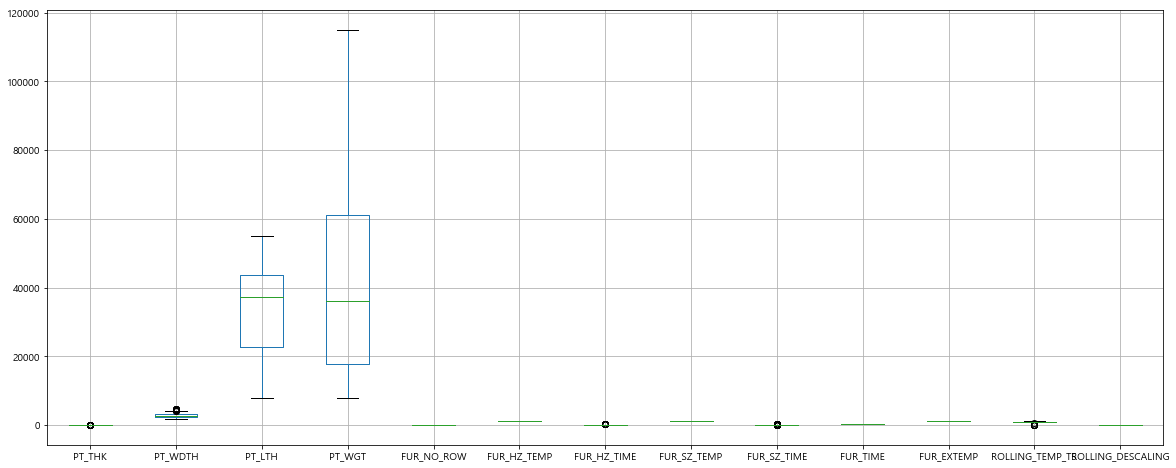

In [17]:
#이상치확인
df_raw.boxplot(figsize = (20,8))


 ### 탐색적 분석


In [18]:
#불량,양품 차이확인
df_count = df_raw['SCALE'].value_counts()
df_count.plot.bar().set_ylim([0,1000]) 

(0, 1000)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001FE5CB48860>,
      dtype=object)

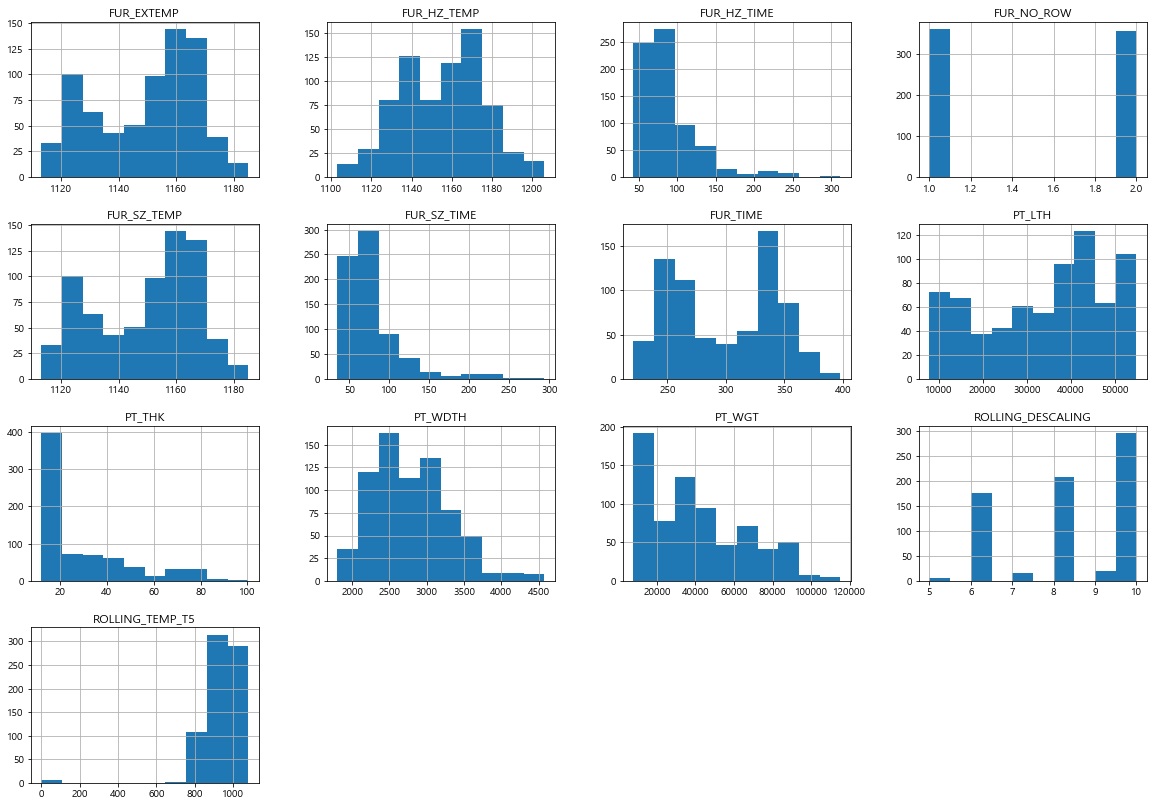

In [19]:
#히스토그램
df_raw.hist(figsize = (20,14))

In [20]:
#불량,양품 히스토그램
df_raw.hist(column = 'FUR_EXTEMP',by = 'SCALE')

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001FE5CE44710>,
      dtype=object)

In [25]:
#train/test Data 비율 7:3 분할
df_train, df_test = train_test_split(df_raw, # 데이터
                                     test_size = 0.3, # test 데이터의 비율
                                     random_state = 1234)  # random state

print("train data size : {}".format(df_train.shape))
print("test data size : {}".format(df_test.shape))

train data size : (504, 15)
test data size : (216, 15)


### 의사결정나무

In [30]:
tree_uncustomized = DecisionTreeRegressor(random_state = 1234)
tree_uncustomized.fit(df_train_x, df_train_y)

print("score on training set: {:3f}".format(tree_uncustomized.score(df_train_x, df_train_y)))
print("score on test set: {:3f}".format(tree_uncustomized.score(df_test_x, df_test_y)))


score on training set: 1.000000
score on test set: 0.937057


In [33]:
print(tree_uncustomized)
print("Train DATA 설명력 : ")
print(tree_uncustomized.score(df_train_x,df_train_y))
print("Test DATA 설명력 : ")
print(tree_uncustomized.score(df_test_x,df_test_y))
#train data 1.0으로 과대 적합

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=1234, splitter='best')
Train DATA 설명력 : 
1.0
Test DATA 설명력 : 
0.9370568237008257


In [36]:
tree_uncustomized

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=1234, splitter='best')

In [37]:
# train 및 test 정확도 결과 저장용
train_accuracy = []; test_accuracy = []
# max_depth: 최대 깊이 변경
para_depth = [depth for depth in range(1, 11)]

for v_max_depth in para_depth:
    tree = DecisionTreeClassifier(max_depth = v_max_depth, random_state=1234)
    tree.fit(df_train_x, df_train_y)
    train_accuracy.append(tree.score(df_train_x, df_train_y))
    test_accuracy.append(tree.score(df_test_x, df_test_y))

# 데이터 테이블로 저장
df_accuracy_depth = pd.DataFrame()
df_accuracy_depth["Depth"] = para_depth
df_accuracy_depth["TrainAccuracy"] = train_accuracy
df_accuracy_depth["TestAccuracy"] = test_accuracy
df_accuracy_depth.round(3)

Depth  TrainAccuracy  TestAccuracy
0      1          0.887         0.898
1      2          0.929         0.944
2      3          0.958         0.972
3      4          0.966         0.977
4      5          0.968         0.977
5      6          0.972         0.977
6      7          0.972         0.977
7      8          0.976         0.977
8      9          0.982         0.977
9     10          0.982         0.977

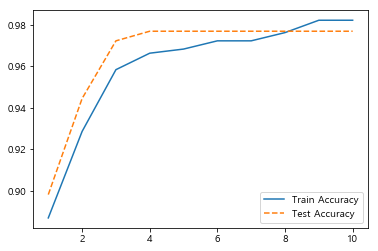

In [38]:
# 정확도를 그래프로 표현
plt.plot(para_depth, train_accuracy, linestyle = "-", label = "Train Accuracy")
plt.plot(para_depth, test_accuracy, linestyle = "--", label = "Test Accuracy")

plt.legend()

In [39]:
# train 및 test 정확도 결과 저장용
train_accuracy = []; test_accuracy = []
# min_samples_split: 분할하기 위한 노드의 최소 샘플 수 
para_split = [n_split for n_split in range(2, 11)]

for v_min_samples_split in para_split:
    tree = DecisionTreeClassifier(min_samples_split = v_min_samples_split, max_depth = 8, random_state=1234)
    tree.fit(df_train_x, df_train_y)
    train_accuracy.append(tree.score(df_train_x, df_train_y))
    test_accuracy.append(tree.score(df_test_x, df_test_y))

# 데이터 테이블로 저장
df_accuracy_split = pd.DataFrame()
df_accuracy_split["MinSamplesSplit"] = para_split
df_accuracy_split["TrainAccuracy"] = train_accuracy
df_accuracy_split["TestAccuracy"] = test_accuracy
df_accuracy_split.round(3)

MinSamplesSplit  TrainAccuracy  TestAccuracy
0                2          0.976         0.977
1                3          0.976         0.977
2                4          0.974         0.972
3                5          0.974         0.972
4                6          0.970         0.977
5                7          0.970         0.977
6                8          0.970         0.977
7                9          0.970         0.977
8               10          0.970         0.977

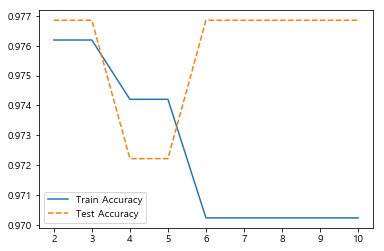

In [40]:
# 정확도를 그래프로 표현
plt.plot(para_split, train_accuracy, linestyle = "-", label = "Train Accuracy")
plt.plot(para_split, test_accuracy, linestyle = "--", label = "Test Accuracy")
plt.legend()

In [41]:
# train 및 test 정확도 결과 저장용
train_accuracy = []; test_accuracy = []
# min_samples_leaf: 잎사귀 수 제한
para_leaf = [n_leaf * 10 for n_leaf in range(1, 11)]

for v_min_samples_leaf in para_leaf:
    tree = DecisionTreeClassifier(min_samples_split=4, min_samples_leaf = v_min_samples_leaf, max_depth = 8, random_state=1234)
    tree.fit(df_train_x, df_train_y)
    train_accuracy.append(tree.score(df_train_x, df_train_y))
    test_accuracy.append(tree.score(df_test_x, df_test_y))

# 데이터 테이블로 저장
df_accuracy_leaf = pd.DataFrame()
df_accuracy_leaf["MinSamplesLeaf"] = para_leaf
df_accuracy_leaf["TrainAccuracy"] = train_accuracy
df_accuracy_leaf["TestAccuracy"] = test_accuracy
df_accuracy_leaf.round(3)

MinSamplesLeaf  TrainAccuracy  TestAccuracy
0              10          0.980         0.991
1              20          0.954         0.963
2              30          0.897         0.903
3              40          0.887         0.898
4              50          0.887         0.898
5              60          0.887         0.898
6              70          0.887         0.898
7              80          0.887         0.898
8              90          0.887         0.898
9             100          0.887         0.898

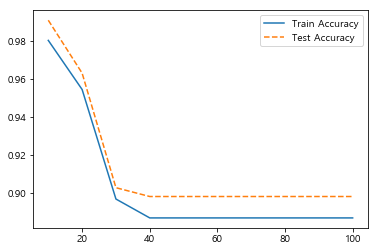

In [42]:
# 정확도를 그래프로 표현
plt.plot(para_leaf, train_accuracy, linestyle = "-", label = "Train Accuracy")
plt.plot(para_leaf, test_accuracy, linestyle = "--", label = "Test Accuracy")
plt.legend()

In [43]:
tree_final = DecisionTreeClassifier(max_depth = 8, min_samples_split=4, min_samples_leaf = 30, random_state=1234)
tree_final.fit(df_train_x, df_train_y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=8,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=30, min_samples_split=4,
            min_weight_fraction_leaf=0.0, presort=False, random_state=1234,
            splitter='best')

In [45]:
# 평가
y_pred = tree_final.predict(df_test_x)
print("Accuracy: {0:.3f}\n".format(tree_final.score(df_test_x, df_test_y)))
print("Confusion matrix: \n{}".format(confusion_matrix(df_test_y, y_pred)))

Accuracy: 0.903

Confusion matrix: 
[[138   7]
 [ 14  57]]


In [46]:
# tree.feature_importances_로 설명변수 중요도 확인 및 테이블로 저장
df_importance = pd.DataFrame()
df_importance["Feature"] = v_feature_names
df_importance["Importance"] = tree_final.feature_importances_

# df_feature_importance의 테이블을 중요도별로 정렬
df_importance.sort_values("Importance", ascending=False, inplace = True)
df_importance.round(3)

Feature  Importance
11    ROLLING_TEMP_T5       0.857
7         FUR_SZ_TEMP       0.103
5         FUR_HZ_TEMP       0.026
2              PT_LTH       0.007
0              PT_THK       0.004
3              PT_WGT       0.002
1             PT_WDTH       0.000
4          FUR_NO_ROW       0.000
6         FUR_HZ_TIME       0.000
8         FUR_SZ_TIME       0.000
9            FUR_TIME       0.000
10         FUR_EXTEMP       0.000
12  ROLLING_DESCALING       0.000
13            HSB_미적용       0.000
14             HSB_적용       0.000

Text(0, 0.5, '설명변수')

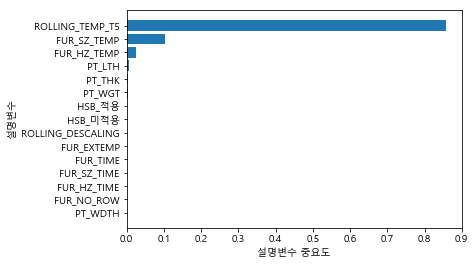

In [47]:
# 설명변수 중요도 그래프
# 중요도가 높은 변수를 상위에 그림. 
df_importance.sort_values("Importance", ascending=True, inplace = True)
coordinates = range(len(df_importance))
plt.barh(y = coordinates, width = df_importance["Importance"])
plt.yticks(coordinates, df_importance["Feature"])
plt.xlabel("설명변수 중요도")
plt.ylabel("설명변수")

### 랜덤포레스트

In [48]:
df_raw_dummy=pd.get_dummies(df_raw)
print(df_raw_dummy.isnull().sum())
print(df_raw_dummy.head())

PT_THK               0
PT_WDTH              0
PT_LTH               0
PT_WGT               0
FUR_NO_ROW           0
FUR_HZ_TEMP          0
FUR_HZ_TIME          0
FUR_SZ_TEMP          0
FUR_SZ_TIME          0
FUR_TIME             0
FUR_EXTEMP           0
ROLLING_TEMP_T5      0
ROLLING_DESCALING    0
SCALE_불량             0
SCALE_양품             0
HSB_미적용              0
HSB_적용               0
dtype: int64
   PT_THK  PT_WDTH  PT_LTH  PT_WGT  FUR_NO_ROW  FUR_HZ_TEMP  FUR_HZ_TIME  \
0   32.25     3707   15109   14180           1         1144          116   
1   32.25     3707   15109   14180           2         1144          122   
2   33.27     3619   19181   18130           1         1129          116   
3   33.27     3619   19181   18130           2         1152          125   
4   38.33     3098   13334   12430           1         1140          134   

   FUR_SZ_TEMP  FUR_SZ_TIME  FUR_TIME  FUR_EXTEMP  ROLLING_TEMP_T5  \
0         1133           59       282        1133              934   

In [49]:
df_raw_y=df_raw_dummy["SCALE_양품"]
df_raw_x=df_raw_dummy.drop(["SCALE_양품","SCALE_불량"],axis=1,inplace=False)

df_train_x,df_test_x,df_train_y,df_test_y = train_test_split(df_raw_x,df_raw_y,test_size=0.3,random_state=1234)

In [50]:
# 랜덤 포레스트 모델 생성: RandomForestClassifier
rf_uncustomized = RandomForestClassifier(random_state=1234)
rf_uncustomized.fit(df_train_x, df_train_y)
# train 데이터 셋 정확도
print("Accuracy on training set: {:.3f}".format(rf_uncustomized.score(df_train_x, df_train_y)))
# test 데이터 셋 정확도
print("Accuracy on test set: {:.3f}".format(rf_uncustomized.score(df_test_x, df_test_y)))

Accuracy on training set: 1.000
Accuracy on test set: 0.963


C:\Users\pobby\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [52]:
print("모델 파라미터 조정 : n_estimators")
train_score=[];test_score=[];minus_score=[]
para_n_tree = [n_tree*5 for n_tree in range(1,21)]

for v_n_estimators in para_n_tree:
    rf=RandomForestRegressor(n_estimators=v_n_estimators, random_state=1234)
    rf.fit(df_train_x,df_train_y)
    train_score.append((rf.score(df_train_x,df_train_y)))
    test_score.append((rf.score(df_test_x, df_test_y)))
    minus_score.append(rf.score(df_train_x,df_train_y)-rf.score(df_test_x, df_test_y))
    
df_score_n = pd.DataFrame()
df_score_n["n_estimators"]=para_n_tree
df_score_n["TrainScore"]= train_score
df_score_n["TestScore"]=test_score
df_score_n["minusscore"]=minus_score

모델 파라미터 조정 : n_estimators


In [53]:
df_score_n.round(3)


n_estimators  TrainScore  TestScore  minusscore
0              5       0.970      0.911       0.059
1             10       0.977      0.942       0.035
2             15       0.979      0.939       0.040
3             20       0.980      0.942       0.039
4             25       0.981      0.939       0.042
5             30       0.980      0.940       0.041
6             35       0.981      0.941       0.040
7             40       0.981      0.940       0.041
8             45       0.980      0.939       0.042
9             50       0.981      0.937       0.044
10            55       0.981      0.935       0.046
11            60       0.981      0.933       0.047
12            65       0.979      0.933       0.047
13            70       0.980      0.935       0.046
14            75       0.980      0.935       0.045
15            80       0.980      0.933       0.047
16            85       0.980      0.934       0.046
17            90       0.980      0.933       0.047
18            95       0.980      0.931       0.049
19           100       0.980      0.930       0.050

In [54]:
plt.plot(para_n_tree,train_score,linestyle="-",label="Train Score")
plt.plot(para_n_tree,test_score,linestyle="-",label="Test Score")
plt.ylabel("score"); plt.xlabel("n_estimators")
plt.legend()
plt.show()

In [55]:
# error 저장 리스트
oob_error = []

for v_n_estimator in range(1, 151):
    rf = RandomForestClassifier(n_estimators = v_n_estimator, oob_score = True, random_state= 1234)
    rf.fit(df_train_x, df_train_y)
    oob_error.append(1 - rf.oob_score_)

C:\Users\pobby\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:458: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\pobby\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:463: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
C:\Users\pobby\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:458: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\pobby\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:463: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
C:\Users\pobby\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:458: UserWarning: Some inputs do not have OOB scores. This probably me

In [56]:
oob_error

[0.45039682539682535,
 0.29960317460317465,
 0.22817460317460314,
 0.19246031746031744,
 0.17658730158730163,
 0.1607142857142857,
 0.13888888888888884,
 0.1329365079365079,
 0.10912698412698407,
 0.10515873015873012,
 0.09722222222222221,
 0.08730158730158732,
 0.07738095238095233,
 0.06944444444444442,
 0.06150793650793651,
 0.06349206349206349,
 0.06150793650793651,
 0.059523809523809534,
 0.05753968253968256,
 0.0535714285714286,
 0.0535714285714286,
 0.04960317460317465,
 0.051587301587301626,
 0.04960317460317465,
 0.045634920634920584,
 0.04960317460317465,
 0.04960317460317465,
 0.04960317460317465,
 0.051587301587301626,
 0.0535714285714286,
 0.051587301587301626,
 0.04960317460317465,
 0.051587301587301626,
 0.0535714285714286,
 0.04761904761904767,
 0.045634920634920584,
 0.045634920634920584,
 0.045634920634920584,
 0.04761904761904767,
 0.04166666666666663,
 0.04166666666666663,
 0.04166666666666663,
 0.04761904761904767,
 0.045634920634920584,
 0.045634920634920584,
 0.04

In [57]:
# 그래프로 표현
plt.plot(range(1, 151), oob_error)
plt.ylabel("oob error")
plt.xlabel("n_estimators")

Text(0.5, 0, 'n_estimators')

In [73]:
# train 및 test 정확도 결과 저장용
train_accuracy = []; test_accuracy = [] ;minus_score = []
# max_depth: 최대 깊이 변경
para_depth = [depth for depth in range(1, 11)]

for v_max_depth in para_depth:
    rf = RandomForestClassifier(max_depth = v_max_depth, n_estimators = 20, random_state=1234)
    rf.fit(df_train_x, df_train_y)
    train_accuracy.append(rf.score(df_train_x, df_train_y))
    test_accuracy.append(rf.score(df_test_x, df_test_y))
    minus_score.append(rf.score(df_train_x,df_train_y)-rf.score(df_test_x, df_test_y))
    
# 데이터 테이블로 저장
df_accuracy_depth = pd.DataFrame()
df_accuracy_depth["Depth"] = para_depth
df_accuracy_depth["TrainAccuracy"] = train_accuracy
df_accuracy_depth["TestAccuracy"] = test_accuracy
df_accuracy_depth["minus"] = minus_score

In [74]:
# 테이블 결과
df_accuracy_depth.round(3)

Depth  TrainAccuracy  TestAccuracy  minus
0      1          0.756         0.764 -0.008
1      2          0.913         0.917 -0.004
2      3          0.948         0.968 -0.019
3      4          0.960         0.972 -0.012
4      5          0.962         0.972 -0.010
5      6          0.962         0.972 -0.010
6      7          0.976         0.972  0.004
7      8          0.984         0.968  0.017
8      9          1.000         0.981  0.019
9     10          0.998         0.972  0.026

In [75]:
# 정확도를 그래프로 표현
plt.plot(para_depth, train_accuracy, linestyle = "-", label = "Train Accuracy")
plt.plot(para_depth, test_accuracy, linestyle = "--", label = "Test Accuracy")
plt.xlabel("max depth"); plt.ylabel("accuracy")
plt.legend()

In [76]:
# train 및 test 정확도 결과 저장용
train_accuracy = []; test_accuracy = []
# min_samples_split: 분할하기 위한 노드의 최소 샘플 수 
para_split = [n_split * 10 for n_split in range(1, 11)]

for v_min_samples_split in para_split:
    rf = RandomForestClassifier(min_samples_split = v_min_samples_split, max_depth = 7,
                                n_estimators = 20, random_state=1234)
    rf.fit(df_train_x, df_train_y)
    train_accuracy.append(rf.score(df_train_x, df_train_y))
    test_accuracy.append(rf.score(df_test_x, df_test_y))

# 데이터 테이블로 저장
df_accuracy_split = pd.DataFrame()
df_accuracy_split["MinSamplesSplit"] = para_split
df_accuracy_split["TrainAccuracy"] = train_accuracy
df_accuracy_split["TestAccuracy"] = test_accuracy

In [77]:
# 테이블 결과
df_accuracy_split.round(3)

MinSamplesSplit  TrainAccuracy  TestAccuracy
0               10          0.968         0.972
1               20          0.970         0.972
2               30          0.964         0.972
3               40          0.962         0.972
4               50          0.962         0.972
5               60          0.960         0.972
6               70          0.960         0.972
7               80          0.958         0.972
8               90          0.960         0.972
9              100          0.958         0.972

In [78]:
# 정확도를 그래프로 표현
plt.plot(para_split, train_accuracy, linestyle = "-", label = "Train Accuracy")
plt.plot(para_split, test_accuracy, linestyle = "--", label = "Test Accuracy")
plt.xlabel("min samples split"); plt.ylabel("accuracy")
plt.legend()

In [79]:
#파라미터조정
train_score=[];test_score=[];difference_score=[]
para_leaf = [n_leaf*1 for n_leaf in range(1,21)]

for v_min_samples_leaf in para_leaf:
    rf=RandomForestRegressor(min_samples_split = 20, max_depth = 7,
                             n_estimators = 20,
                             min_samples_leaf=v_min_samples_leaf,random_state=1234)
    rf.fit(df_train_x,df_train_y)
    train_score.append((rf.score(df_train_x,df_train_y)))
    test_score.append((rf.score(df_test_x, df_test_y)))
    difference_score.append(rf.score(df_train_x,df_train_y)-rf.score(df_test_x, df_test_y))
df_score_n = pd.DataFrame()
df_score_n["MinSamplesLeaf"]=para_leaf
df_score_n["TrainScore"]= train_score
df_score_n["TestScore"]=test_score
df_score_n["differenceScore"]=difference_score


In [80]:
print(df_score_n.round(3))


    MinSamplesLeaf  TrainScore  TestScore  differenceScore
0                1       0.911      0.915           -0.004
1                2       0.915      0.924           -0.010
2                3       0.910      0.920           -0.009
3                4       0.905      0.918           -0.013
4                5       0.903      0.920           -0.017
5                6       0.893      0.911           -0.017
6                7       0.888      0.905           -0.017
7                8       0.889      0.898           -0.009
8                9       0.887      0.895           -0.007
9               10       0.879      0.887           -0.008
10              11       0.868      0.878           -0.010
11              12       0.853      0.866           -0.013
12              13       0.830      0.848           -0.018
13              14       0.787      0.791           -0.005
14              15       0.745      0.727            0.018
15              16       0.706      0.668            0.0

In [81]:
plt.plot(para_leaf,train_score,linestyle="-",label="Train Score")
plt.plot(para_leaf,test_score,linestyle="-",label="Test Score")
plt.ylabel("score"); plt.xlabel("MinSamplesLeaf")
plt.legend()
plt.show()

In [82]:
# 최종 모델
rf_final = RandomForestClassifier(min_samples_leaf =13 , min_samples_split=20,
                                  max_depth = 7, n_estimators = 20,
                                  random_state=1234)
rf_final.fit(df_train_x, df_train_y)
# 평가
y_pred = rf_final.predict(df_test_x)

# train 데이터 셋 정확도
print("Accuracy on training set: {:.3f}".format(rf_final.score(df_train_x, df_train_y)))
# test 데이터 셋 정확도
print("Accuracy on test set: {:.3f}\n".format(rf_final.score(df_test_x, df_test_y)))
# confusion matrix
print("Confusion matrix: \n{}".format(confusion_matrix(df_test_y, y_pred)))

Accuracy on training set: 0.927
Accuracy on test set: 0.921

Confusion matrix: 
[[ 54  17]
 [  0 145]]


In [83]:
# 변수명
v_feature_names = df_train_x.columns
# tree.feature_importances_로 설명변수 중요도 확인 및 테이블로 저장
df_importance = pd.DataFrame()
df_importance ["Feature"] = v_feature_names
df_importance ["Importance"] = rf_final.feature_importances_
# df_feature_importance의 테이블을 중요도별로 정렬
df_importance .sort_values("Importance", ascending=False, inplace = True)
df_importance .round(3)

Feature  Importance
11    ROLLING_TEMP_T5       0.427
7         FUR_SZ_TEMP       0.099
1             PT_WDTH       0.097
10         FUR_EXTEMP       0.084
0              PT_THK       0.057
12  ROLLING_DESCALING       0.039
3              PT_WGT       0.035
5         FUR_HZ_TEMP       0.034
6         FUR_HZ_TIME       0.031
8         FUR_SZ_TIME       0.027
2              PT_LTH       0.024
14             HSB_적용       0.019
9            FUR_TIME       0.014
13            HSB_미적용       0.011
4          FUR_NO_ROW       0.002

Text(0, 0.5, '설명변수')

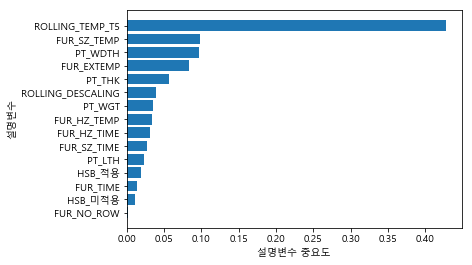

In [84]:
# 설명변수 중요도 그래프
# 중요도가 높은 변수를 상위에 그림 
df_importance .sort_values("Importance", ascending=True, inplace = True)
coordinates = range(len(df_importance ))
plt.barh(y = coordinates, width = df_importance ["Importance"])
plt.yticks(coordinates, df_importance ["Feature"])
plt.xlabel("설명변수 중요도")
plt.ylabel("설명변수")

### 그래디언트 부스팅

In [85]:
# 그래디언트 부스팅 모델 생성: GradientBoostingClassifier
gb_uncustomized = GradientBoostingClassifier(random_state = 1234)
gb_uncustomized.fit(df_train_x, df_train_y)
# train 데이터 셋 정확도
print("Accuracy on training set: {:.3f}".format(gb_uncustomized.score (df_train_x, df_train_y)))
# test 데이터 셋 정확도
print("Accuracy on test set: {:.3f}".format(gb_uncustomized.score (df_test_x, df_test_y)))

Accuracy on training set: 1.000
Accuracy on test set: 1.000


In [87]:
# train 및 test 정확도 결과 저장용
train_accuracy = []; test_accuracy = []
# learning_rate 학습률 변경: 0.1 ~ 0.9
para_lr = [lr * 0.1 for lr in range(1, 10)]

for v_learning_rate in para_lr:
    gb = GradientBoostingClassifier(learning_rate = v_learning_rate, random_state = 1234)
    gb.fit(df_train_x, df_train_y)
    train_accuracy.append(gb.score(df_train_x, df_train_y))
    test_accuracy.append(gb.score(df_test_x, df_test_y))

# 데이터 테이블로 저장
df_accuracy_lr = pd.DataFrame()
df_accuracy_lr["LearningRate"] = para_lr
df_accuracy_lr["TrainAccuracy"] = train_accuracy
df_accuracy_lr["TestAccuracy"] = test_accuracy

In [88]:
# LearningRate별 정확도 테이블
df_accuracy_lr.round(3)

LearningRate  TrainAccuracy  TestAccuracy
0           0.1            1.0         1.000
1           0.2            1.0         1.000
2           0.3            1.0         1.000
3           0.4            1.0         1.000
4           0.5            1.0         1.000
5           0.6            1.0         0.986
6           0.7            1.0         0.991
7           0.8            1.0         0.977
8           0.9            1.0         0.981

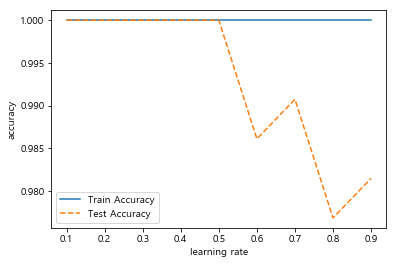

In [89]:
# LearningRate별 정확도 그래프로 확인
plt.plot(para_lr, train_accuracy, linestyle = "-", label = "Train Accuracy")
plt.plot(para_lr, test_accuracy, linestyle = "--", label = "Test Accuracy")
plt.ylabel("accuracy"); plt.xlabel("learning rate")
plt.legend()

In [91]:
# train 및 test 정확도 결과 저장용
train_accuracy = []; test_accuracy = []
# n_estimatos: 트리 수 변경: 10~150
para_n_tree = [n_tree * 10 for n_tree in range(1, 16)]

for v_n_estimators in para_n_tree:
    gb = GradientBoostingClassifier(n_estimators = v_n_estimators, learning_rate = 0.5, random_state = 1234)
    gb.fit(df_train_x, df_train_y)
    train_accuracy.append(gb.score(df_train_x, df_train_y))
    test_accuracy.append(gb.score(df_test_x, df_test_y))

# 데이터 테이블로 저장
df_accuracy_n = pd.DataFrame()
df_accuracy_n["Estimators"] = para_n_tree
df_accuracy_n["TrainAccuracy"] = train_accuracy
df_accuracy_n["TestAccuracy"] = test_accuracy

In [92]:
# n_estimators별 정확도 테이블
df_accuracy_n.round(3)

Estimators  TrainAccuracy  TestAccuracy
0           10          0.998         0.995
1           20          1.000         0.995
2           30          1.000         0.995
3           40          1.000         1.000
4           50          1.000         1.000
5           60          1.000         1.000
6           70          1.000         1.000
7           80          1.000         1.000
8           90          1.000         1.000
9          100          1.000         1.000
10         110          1.000         1.000
11         120          1.000         1.000
12         130          1.000         1.000
13         140          1.000         1.000
14         150          1.000         1.000

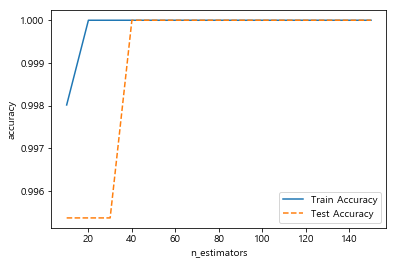

In [93]:
# 정확도를 그래프로 표현
plt.plot(para_n_tree, train_accuracy, linestyle = "-", label = "Train Accuracy")
plt.plot(para_n_tree, test_accuracy, linestyle = "--", label = "Test Accuracy")
plt.ylabel("accuracy"); plt.xlabel("n_estimators")
plt.legend()

In [94]:
# train 및 test 정확도 결과 저장용
train_accuracy = []; test_accuracy = []
# max_depth: 최대 깊이 변경
para_depth = [depth for depth in range(1, 11)]

for v_max_depth in para_depth:
    gb = GradientBoostingClassifier(max_depth = v_max_depth,
                                    n_estimators = 40, learning_rate = 0.5,random_state=1234)
    gb.fit(df_train_x, df_train_y)
    train_accuracy.append(gb.score(df_train_x, df_train_y))
    test_accuracy.append(gb.score(df_test_x, df_test_y))

# 데이터 테이블로 저장
df_accuracy_depth = pd.DataFrame()
df_accuracy_depth["Depth"] = para_depth
df_accuracy_depth["TrainAccuracy"] = train_accuracy
df_accuracy_depth["TestAccuracy"] = test_accuracy

In [95]:
# max_depth별 정확도 테이블
df_accuracy_depth.round(3)

Depth  TrainAccuracy  TestAccuracy
0      1          0.976         0.977
1      2          1.000         1.000
2      3          1.000         1.000
3      4          1.000         1.000
4      5          1.000         1.000
5      6          1.000         0.995
6      7          1.000         1.000
7      8          1.000         0.995
8      9          1.000         1.000
9     10          1.000         1.000

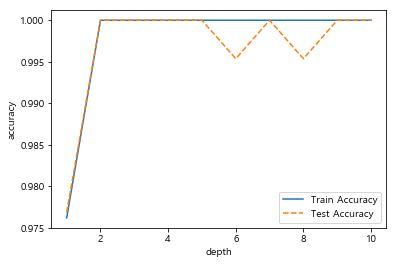

In [96]:
# 정확도를 그래프로 표현
plt.plot(para_depth, train_accuracy, linestyle = "-", label = "Train Accuracy")
plt.plot(para_depth, test_accuracy, linestyle = "--", label = "Test Accuracy")
plt.ylabel("accuracy"); plt.xlabel("depth")
plt.legend()

In [97]:
# train 및 test 정확도 결과 저장용
train_accuracy = []; test_accuracy = []
# min_samples_split: 분할하기 위한 노드의 최소 샘플 수 
para_split = [n_split * 10 for n_split in range(2, 11)]

for v_min_samples_split in para_split:
    gb = GradientBoostingClassifier(min_samples_split = v_min_samples_split,
                                    max_depth = 5,n_estimators = 40, learning_rate = 0.5, random_state=1234)
    gb.fit(df_train_x, df_train_y)
    train_accuracy.append(gb.score(df_train_x, df_train_y))
    test_accuracy.append(gb.score(df_test_x, df_test_y))

# 데이터 테이블로 저장
df_accuracy_split = pd.DataFrame()
df_accuracy_split["MinSamplesSplit"] = para_split
df_accuracy_split["TrainAccuracy"] = train_accuracy
df_accuracy_split["TestAccuracy"] = test_accuracy

In [98]:
# min_samples_leaf별 정확도 테이블
df_accuracy_split.round(3)

MinSamplesSplit  TrainAccuracy  TestAccuracy
0               20            1.0         0.995
1               30            1.0         0.995
2               40            1.0         0.995
3               50            1.0         0.995
4               60            1.0         0.995
5               70            1.0         1.000
6               80            1.0         0.995
7               90            1.0         1.000
8              100            1.0         1.000

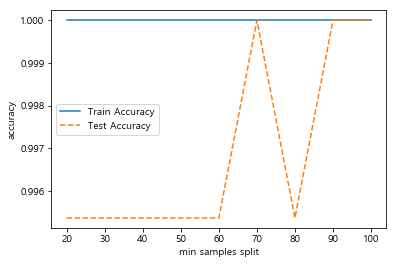

In [99]:
# 정확도를 그래프로 표현
plt.plot(para_split, train_accuracy, linestyle = "-", label = "Train Accuracy")
plt.plot(para_split, test_accuracy, linestyle = "--", label = "Test Accuracy")
plt.ylabel("accuracy"); plt.xlabel("min samples split")
plt.legend()

In [101]:
# train 및 test 정확도 결과 저장용
train_accuracy = []; test_accuracy = []
# min_samples_leaf: 잎사귀 수 제한
para_leaf = [n_leaf * 10 for n_leaf in range(1, 11)]

for v_min_samples_leaf in para_leaf:
    gb = GradientBoostingClassifier(min_samples_leaf = v_min_samples_leaf, min_samples_split = 70,
                                     max_depth = 5, n_estimators = 40, learning_rate = 0.5, random_state=1234)
    gb.fit(df_train_x, df_train_y)
    train_accuracy.append(gb.score(df_train_x, df_train_y))
    test_accuracy.append(gb.score(df_test_x, df_test_y))

# 데이터 테이블로 저장
df_accuracy_leaf = pd.DataFrame()
df_accuracy_leaf["MinSamplesLeaf"] = para_leaf
df_accuracy_leaf["TrainAccuracy"] = train_accuracy
df_accuracy_leaf["TestAccuracy"] = test_accuracy

In [102]:
# min_samples_leaf별 정확도 테이블
df_accuracy_leaf.round(3)

MinSamplesLeaf  TrainAccuracy  TestAccuracy
0              10          1.000         0.995
1              20          1.000         0.986
2              30          1.000         0.921
3              40          1.000         0.912
4              50          1.000         0.912
5              60          0.994         0.931
6              70          0.984         0.931
7              80          0.976         0.903
8              90          0.964         0.931
9             100          0.956         0.931

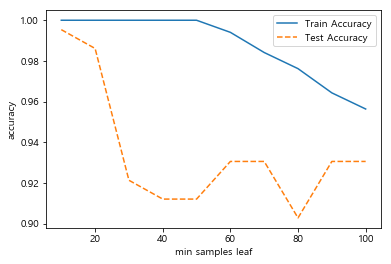

In [103]:
# 정확도를 그래프로 표현
plt.plot(para_leaf, train_accuracy, linestyle = "-", label = "Train Accuracy")
plt.plot(para_leaf, test_accuracy, linestyle = "--", label = "Test Accuracy")
plt.ylabel("accuracy"); plt.xlabel("min samples leaf")
plt.legend()

In [104]:
# 최종 모델
gb_final = GradientBoostingClassifier(min_samples_leaf = 70, min_samples_split = 50,
                                      max_depth = 4, n_estimators = 40, learning_rate = 0.2, random_state=1234)
gb_final.fit(df_train_x, df_train_y)
# 예측
y_pred = gb_final.predict(df_test_x)

# train 데이터 셋 정확도
print("Accuracy on training set: {:.3f}".format(gb_final.score(df_train_x, df_train_y)))
# test 데이터 셋 정확도
print("Accuracy on test set: {:.3f}\n".format(gb_final.score(df_test_x, df_test_y)))
# confusion matrix
print("Confusion matrix: \n{}".format(confusion_matrix(df_test_y, y_pred)))

Accuracy on training set: 0.950
Accuracy on test set: 0.935

Confusion matrix: 
[[ 57  14]
 [  0 145]]


### SVM

In [106]:
svm_uncustomized = SVC(random_state = 1234)
svm_uncustomized.fit(df_train_x, df_train_y)
# train 데이터 셋 정확도
print("Accuracy on training set: {:.3f}".format(svm_uncustomized.score(df_train_x, df_train_y)))
# test 데이터 셋 정확도
print("Accuracy on test set: {:.3f}".format(svm_uncustomized.score(df_test_x, df_test_y)))

Accuracy on training set: 1.000
Accuracy on test set: 0.671


C:\Users\pobby\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


In [107]:
# train 및 test 정확도 결과 저장용
train_accuracy = []; test_accuracy = []
# c: 규제(0.01, 0.1, 1, 10)
para_c = [10 **c for c in range(-2, 2)]

for v_C in para_c:
    svm = SVC(C = v_C, random_state = 1234)
    svm.fit(df_train_x, df_train_y)
    train_accuracy.append(svm.score(df_train_x, df_train_y))
    test_accuracy.append(svm.score(df_test_x, df_test_y))

# 데이터 테이블로 저장
df_accuracy_c = pd.DataFrame()
df_accuracy_c["C"] = para_c
df_accuracy_c["TrainAccuracy"] = train_accuracy
df_accuracy_c["TestAccuracy"] = test_accuracy

C:\Users\pobby\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\pobby\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\pobby\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\pobby\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarni

In [108]:
# C별 정확도 테이블
df_accuracy_c.round(3)

C  TrainAccuracy  TestAccuracy
0   0.01          0.683         0.671
1   0.10          0.683         0.671
2   1.00          1.000         0.671
3  10.00          1.000         0.671

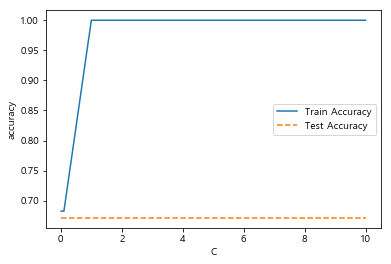

In [109]:
# 정확도를 그래프로 표현
plt.plot(para_c, train_accuracy, linestyle = "-", label = "Train Accuracy")
plt.plot(para_c, test_accuracy, linestyle = "--", label = "Test Accuracy")
plt.ylabel("accuracy"); plt.xlabel("C")
plt.legend()

In [110]:
# train 및 test 정확도 결과 저장용
train_accuracy = []; test_accuracy = []
# gamma: 규제(0.01, 0.1, 1, 10)
para_gamma = [10 **gamma for gamma in range(-2, 2)]

for v_gamma in para_gamma:
    svm = SVC(gamma = v_gamma, C = 0.1, random_state = 1234)
    svm.fit(df_train_x, df_train_y)
    train_accuracy.append(svm.score(df_train_x, df_train_y))
    test_accuracy.append(svm.score(df_test_x, df_test_y))

# 데이터 테이블로 저장
df_accuracy_gamma = pd.DataFrame()
df_accuracy_gamma["gamma"] = para_gamma
df_accuracy_gamma["TrainAccuracy"] = train_accuracy
df_accuracy_gamma["TestAccuracy"] = test_accuracy

In [111]:
# Gamma별 정확도 테이블
df_accuracy_gamma.round(4)

gamma  TrainAccuracy  TestAccuracy
0   0.01         0.6825        0.6713
1   0.10         0.6825        0.6713
2   1.00         0.6825        0.6713
3  10.00         0.6825        0.6713

In [112]:
# 정확도를 그래프로 표현
plt.plot(para_gamma, train_accuracy, linestyle = "-", label = "Train Accuracy")
plt.plot(para_gamma, test_accuracy, linestyle = "--", label = "Test Accuracy")
plt.ylabel("accuracy"); plt.xlabel("gamma")
plt.legend()

In [113]:
# 변수명 저장
v_feature_names = df_train_x.columns
# StandardScaler 적용
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_raw_x)
df_scaled = pd.DataFrame(df_scaled, columns=v_feature_names)
df_scaled.head()

C:\Users\pobby\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\pobby\Anaconda3\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


PT_THK   PT_WDTH    PT_LTH    PT_WGT  FUR_NO_ROW  FUR_HZ_TEMP  \
0  0.155812  1.738951 -1.390441 -1.103810   -0.994460    -0.543782   
1  0.155812  1.738951 -1.390441 -1.103810    1.005571    -0.543782   
2  0.209106  1.568896 -1.095771 -0.944112   -0.994460    -1.263141   
3  0.209106  1.568896 -1.095771 -0.944112    1.005571    -0.160124   
4  0.473482  0.562094 -1.518889 -1.174562   -0.994460    -0.735611   

   FUR_HZ_TIME  FUR_SZ_TEMP  FUR_SZ_TIME  FUR_TIME  FUR_EXTEMP  \
0     0.729972    -0.949149    -0.544097 -0.409268   -0.949149   
1     0.889399    -0.835252    -0.708951 -0.387221   -0.835252   
2     0.729972    -1.632537    -0.654000 -0.409268   -1.632537   
3     0.969113    -1.290843    -0.296815  0.340311   -1.290843   
4     1.208255    -1.233894    -0.846330  0.296219   -1.233894   

   ROLLING_TEMP_T5  ROLLING_DESCALING   HSB_미적용    HSB_적용  
0         0.000734           -0.19693 -0.219169  0.219169  
1         0.028567           -0.19693 -0.219169  0.219169  
2        -0.416748           -0.19693 -0.219169  0.219169  
3        -0.453858           -0.19693 -0.219169  0.219169  
4        -0.565186           -0.19693 -0.219169  0.219169

In [114]:
# 데이터 분할
df_scaled_train_x, df_scaled_test_x = train_test_split(df_scaled, test_size = 0.3,random_state = 1234)
print("train data X size : {}".format(df_scaled_train_x.shape))
print("train data Y size : {}".format(df_scaled_test_x.shape))

train data X size : (504, 15)
train data Y size : (216, 15)


In [115]:
svm_scaled = SVC(random_state=1234)
svm_scaled.fit(df_scaled_train_x, df_train_y)
# train 데이터 셋 정확도
print("Accuracy on training set: {:.3f}".format(svm_scaled.score(df_scaled_train_x, df_train_y)))
# test 데이터 셋 정확도
print("Accuracy on test set: {:.3f}".format(svm_scaled.score(df_scaled_test_x, df_test_y)))

Accuracy on training set: 0.915
Accuracy on test set: 0.894


C:\Users\pobby\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


In [116]:
# train 및 test 정확도 결과 저장용
train_accuracy = []; test_accuracy = []
# c: 규제(0.01, 0.1, 1, 10)
para_c = [10 **c for c in range(-2, 2)]

for v_C in para_c:
    svm = SVC(C = v_C, random_state = 1234)
    svm.fit(df_scaled_train_x, df_train_y)
    train_accuracy.append(svm.score(df_scaled_train_x, df_train_y))
    test_accuracy.append(svm.score(df_scaled_test_x, df_test_y))

# 데이터 테이블로 저장
df_accuracy_c = pd.DataFrame()
df_accuracy_c["C"] = para_c
df_accuracy_c["TrainAccuracy"] = train_accuracy
df_accuracy_c["TestAccuracy"] = test_accuracy

C:\Users\pobby\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\pobby\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\pobby\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\pobby\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarni

In [117]:
# C별 정확도 테이블 
df_accuracy_c.round(3)

C  TrainAccuracy  TestAccuracy
0   0.01          0.683         0.671
1   0.10          0.853         0.875
2   1.00          0.915         0.894
3  10.00          0.948         0.907

In [118]:
# 정확도를 그래프로 표현
plt.plot(para_c, train_accuracy, linestyle = "-", label = "Train Accuracy")
plt.plot(para_c, test_accuracy, linestyle = "--", label = "Test Accuracy")
plt.ylabel("accuracy"); plt.xlabel("C")
plt.legend()

In [119]:
# train 및 test 정확도 결과 저장용
train_accuracy = []; test_accuracy = []
# gamma: 규제(0.01, 0.1, 1, 10)
para_gamma = [10 **gamma for gamma in range(-2, 2)]

for v_gamma in para_gamma:
    svm = SVC(gamma = v_gamma, C = 1, random_state = 1234)
    svm.fit(df_scaled_train_x, df_train_y)
    train_accuracy.append(svm.score(df_scaled_train_x, df_train_y))
    test_accuracy.append(svm.score(df_scaled_test_x, df_test_y))

# 데이터 테이블로 저장
df_accuracy_gamma = pd.DataFrame()
df_accuracy_gamma["gamma"] = para_gamma
df_accuracy_gamma["TrainAccuracy"] = train_accuracy
df_accuracy_gamma["TestAccuracy"] = test_accuracy

In [120]:
# Gamma별 정확도 테이블 
df_accuracy_gamma.round(3)

gamma  TrainAccuracy  TestAccuracy
0   0.01          0.883         0.889
1   0.10          0.919         0.903
2   1.00          0.982         0.796
3  10.00          1.000         0.681

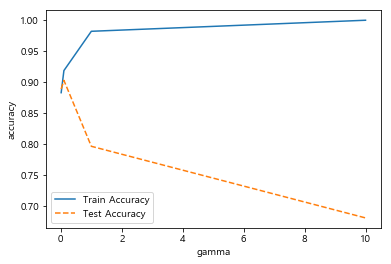

In [121]:
# Gamma별 정확도 그래프로 확인
plt.plot(para_gamma, train_accuracy, linestyle = "-", label = "Train Accuracy")
plt.plot(para_gamma, test_accuracy, linestyle = "--", label = "Test Accuracy")
plt.ylabel("accuracy"); plt.xlabel("gamma")
plt.legend()

In [122]:
# 최종 모델
svc_final = SVC(gamma = 0.1, C = 1, random_state=1234)
svc_final.fit(df_scaled_train_x, df_train_y)
# 평가
y_pred = svc_final.predict(df_scaled_test_x)

# train 데이터 셋 정확도
print("Accucary on training set: {:.3f}".format(svc_final.score(df_scaled_train_x, df_train_y)))
# test 데이터 셋 정확도
print("Accuracy on test set: {:.3f}\n".format(svc_final.score(df_scaled_test_x, df_test_y)))
# confusion matrix
print("Confusion matrix: \n{}".format(confusion_matrix(df_test_y, y_pred)))

Accucary on training set: 0.919
Accuracy on test set: 0.903

Confusion matrix: 
[[ 58  13]
 [  8 137]]
